# OWT

In [2]:
import datasets

In [3]:
tokenized = datasets.load_from_disk('/scratch3/workspace/dhruveshpate_umass_edu-text_diffusion/data/dhruveshpatel/owt-gpt2-1024-split/train')
def length(example):
    example["length"] = len(example["token_ids"])
    return example
lengths = tokenized.map(length, batched=False, num_proc=8)

Loading dataset from disk:   0%|          | 0/120 [00:00<?, ?it/s]

Map (num_proc=8):   0%|          | 0/5329817 [00:00<?, ? examples/s]

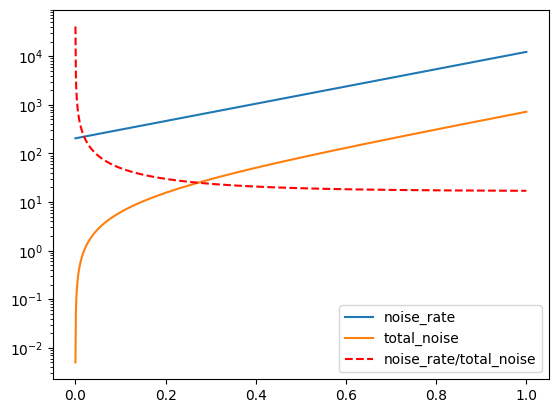

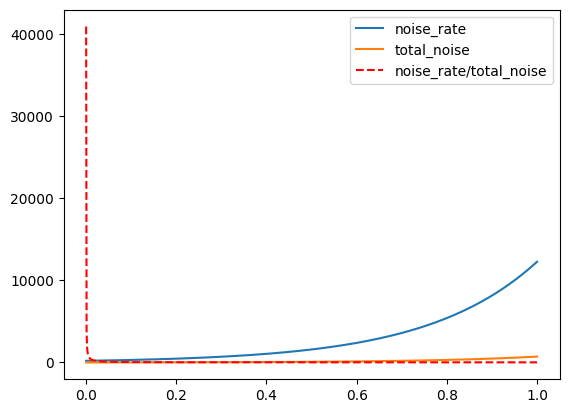

tensor(40955.2656)
tensor(19.2422)
tensor(17.0478)


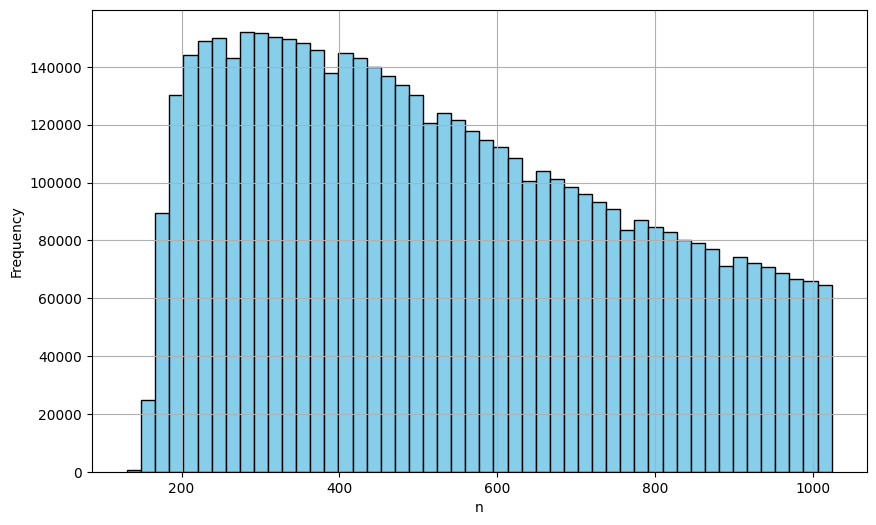

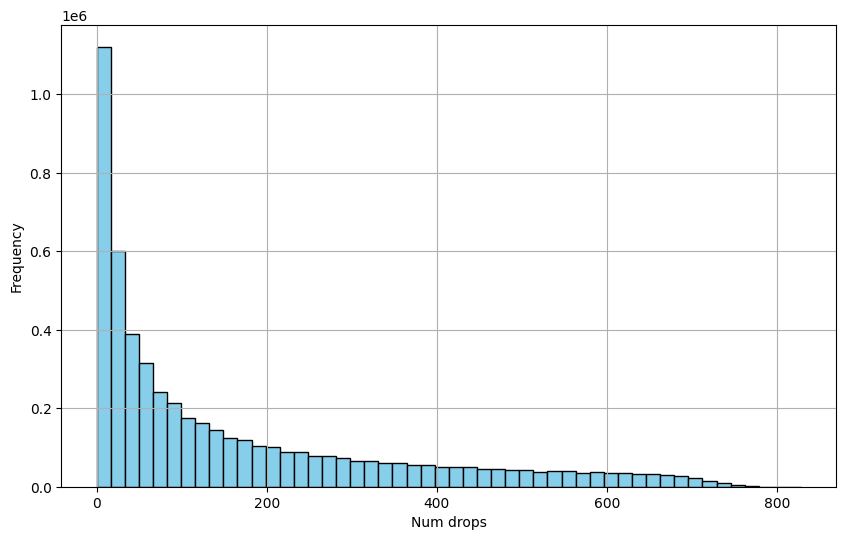

Fraction with zero drops: 0.01855091835235619


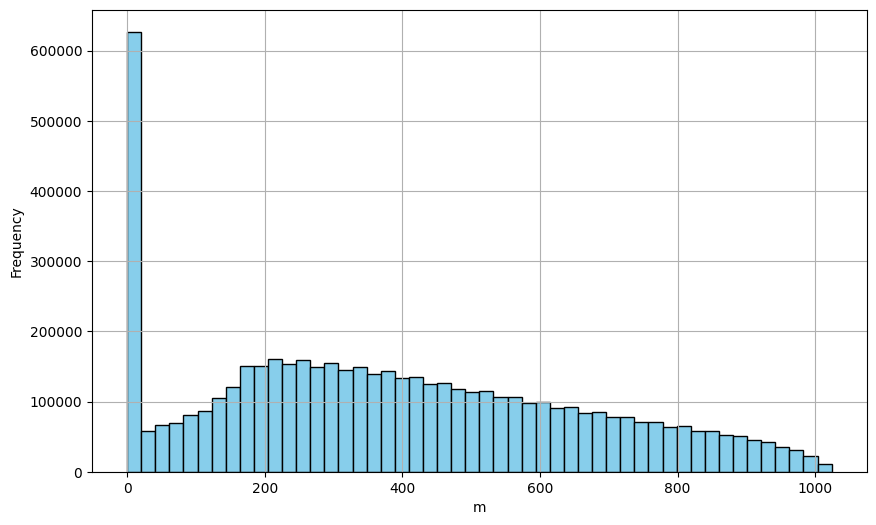

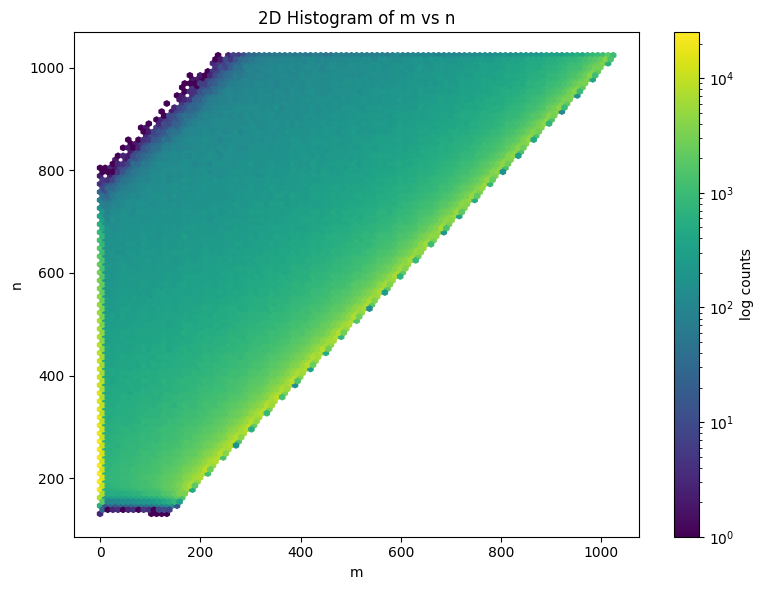

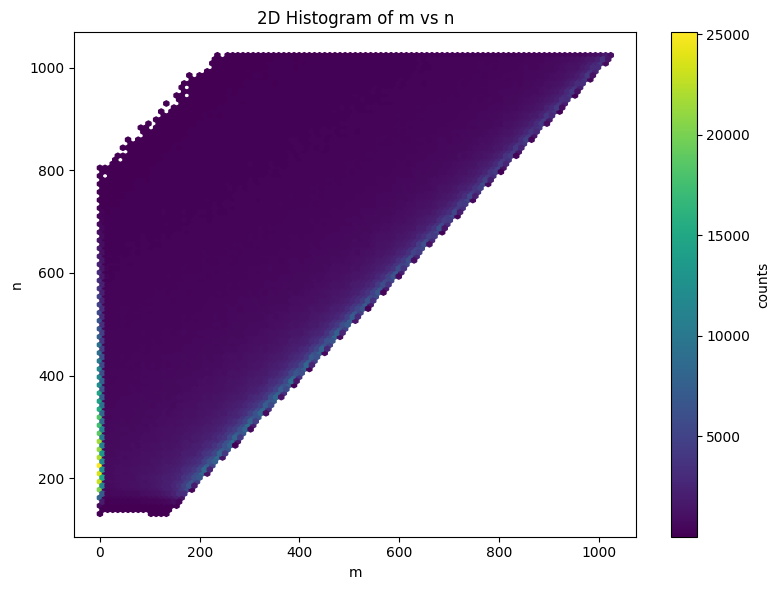

Fraction with m=0: 0.10759900510311127
max wt: 40955.265625, total_noise: 0.005000603850930929, n: 179, m: 178.0, S_: 1.0000277757644653
min wt: 3.855382809878072e-13
min wt: 3.855382809878072e-13, total_noise: 719.2618408203125, n: 141, m: 0.0, S_: 44219418804224.0


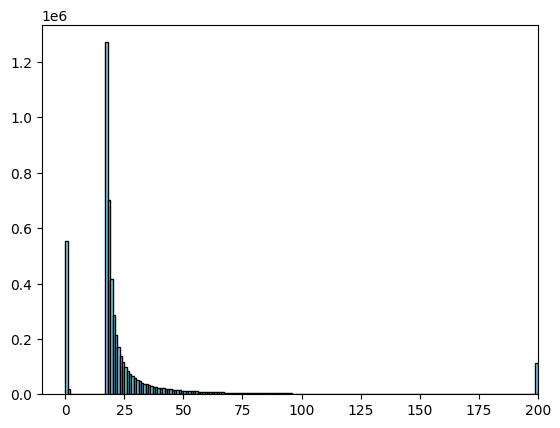

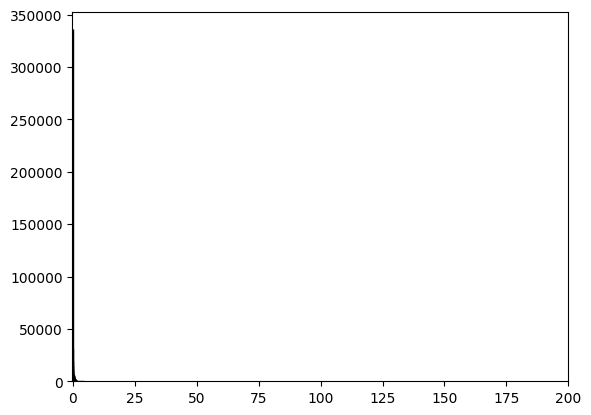

In [22]:
import matplotlib.pyplot as plt
from xlm.lm.idlm.noise_schedule import (
    LogLinearNoiseSchedule,
)
from xlm.lm.idlm.nn import hyp1f1_1_nplus1_vec
import torch
eps = 1e-4
#eps = 1e-3
noise_schedule = LogLinearNoiseSchedule(sigma_min=50, sigma_max=3000, eps=eps)
t = torch.linspace(eps, 1.0, 1000)
noise_rate, total_noise = noise_schedule(t)
plt.plot(t, noise_rate, label="noise_rate")
plt.plot(t, total_noise, label="total_noise")
ratio = noise_rate / total_noise
plt.plot(t, ratio, label="noise_rate/total_noise", color="red", linestyle="--")
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(t, noise_rate, label="noise_rate")
plt.plot(t, total_noise, label="total_noise")
plt.plot(t, ratio, label="noise_rate/total_noise", color="red", linestyle="--")
plt.legend()
plt.show()
print(ratio[0])
print(ratio[len(ratio) // 2])
print(ratio[-1])


t = noise_schedule.sample_t(len(lengths))
noise_rate, total_noise = noise_schedule(t)
ratio = noise_rate / total_noise
n_drops = torch.poisson(total_noise)
lengths_tensor = torch.tensor(lengths["length"])
m = torch.maximum(lengths_tensor - n_drops, torch.tensor([0]))


plt.figure(figsize=(10, 6))
plt.hist(lengths_tensor.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("n")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(n_drops.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("Num drops")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(
    f"Fraction with zero drops: {torch.sum(n_drops == 0).item()/len(n_drops)}"
)

plt.figure(figsize=(10, 6))
plt.hist(m.numpy(), bins=50, color="skyblue", edgecolor="black")
plt.xlabel("m")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


y = lengths_tensor.detach().cpu().numpy()
x = m.detach().cpu().numpy()

# 3a. Using hist2d
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
# hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
# plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, bins="log", mincnt=1)
plt.colorbar(hb, label="log counts")
plt.xlabel("m")
plt.ylabel("n")
plt.title("2D Histogram of m vs n")
plt.tight_layout()
plt.show()


# 3a. Using hist2d
from matplotlib.colors import LogNorm

plt.figure(figsize=(8, 6))
# hb = plt.hist2d(x, y, bins=100, norm=LogNorm(vmin=1))    # you can tweak bins
# plt.colorbar(hb[3], label='counts')
hb = plt.hexbin(x, y, gridsize=100, mincnt=1)
plt.colorbar(hb, label="counts")
plt.xlabel("m")
plt.ylabel("n")
plt.title("2D Histogram of m vs n")
plt.tight_layout()
plt.show()


S_ = hyp1f1_1_nplus1_vec(total_noise, lengths_tensor, K=20)
mask = m == 0
print(f"Fraction with m=0: {mask.sum()/len(mask)}")
S = torch.where(mask, S_, 1.0)
wt = ratio / S
max_wt, max_wt_idx = wt.max(), wt.argmax()
print(
    f"max wt: {max_wt}, total_noise: {total_noise[max_wt_idx]}, n: {lengths_tensor[max_wt_idx]}, m: {m[max_wt_idx]}, S_: {S_[max_wt_idx]}"
)
min_wt, min_wt_idx = wt.min(), wt.argmin()
print(f"min wt: {min_wt}")
print(f"min wt: {min_wt}, total_noise: {total_noise[min_wt_idx]}, n: {lengths_tensor[min_wt_idx]}, m: {m[min_wt_idx]}, S_: {S_[min_wt_idx]}")
max_value = 200  # Define the max value for the x-axis
wt_clipped = torch.clamp(wt, max=max_value)  # Clip the values at max_value
plt.hist(
    wt_clipped.numpy(), bins=max_value, color="skyblue", edgecolor="black"
)
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()

# plot wt only for m=0
plt.hist(wt[mask].numpy(), bins=max_value, color="skyblue", edgecolor="black")
plt.xlim(right=max_value)  # Set the x-axis limit to max_value
plt.show()